In [26]:
#no evesdropper


from qiskit import*
from numpy.random import randint
import random
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt

num_qubits = 10
num_check = 3
alice_state = np.random.randint(2, size = num_qubits)
alice_basis = np.random.randint(2, size = num_qubits)
bob_change = np.random.randint(2, size = num_qubits)
check_bits = sorted(random.sample(range(num_qubits), num_check))


def circ(state, basis, change):
    num_qubits = len(state)
    circuit = QuantumCircuit(num_qubits)
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
        if change[i] == 1:
            circuit.z(i)
            circuit.x(i)
    return circuit
qc = circ(alice_state, alice_basis, bob_change)
simulater = Aer.get_backend('statevector_simulator')
new_circuit = transpile(qc, simulater)
job = simulater.run(new_circuit)
result = job.result()
statevector = result.get_statevector()

def generatekey(alice, bob):
    matrix = []
    for i in range(len(alice)):
        matrix.append((alice[i]+bob[i]) % 2)
    return matrix
key = generatekey(alice_state, bob_change)

def measure(basis, state):
    length = list(range(10))
    circuit1 = QuantumCircuit(len(basis),len(basis))
    circuit1.initialize(state, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit1.h(i)
    #statevector = result.get_statevector()
    circuit1.measure_all()
    #result_list = list(result.keys())[0]
    return circuit1
bobmeasure = measure(alice_basis, statevector)
sampler = StatevectorSampler()
pub =  bobmeasure
job = sampler.run([pub], shots = 1).result()
result = job[0].data.meas.get_counts()
result_list = list(result.keys())[0]
reversed_string = result_list[::-1]
str_array = list(reversed_string)
key_bob = np.array(str_array, dtype=int).astype(np.int32)

def error(raw_key, real_key):
    error_bit = 0
    total_check_bit = 0
    for i in check_bits:
        if raw_key[i] != real_key[i]:
            error_bit += 1
        total_check_bit += 1
    rate = error_bit / total_check_bit
    return rate
error_rate = error(key, key_bob)
print("alice_basis=", alice_basis)
print("alice_state=", alice_state)
print("bob_change=", bob_change)
print("key=", key)
print("key_bob=", key_bob)
print("error_rate=", error_rate)
   

#print(statevector)
#print(alice_state)
#print(alice_basis)

   


alice_basis= [1 0 1 0 0 1 0 1 1 1]
alice_state= [0 1 1 0 1 1 0 0 1 0]
bob_change= [0 1 1 1 0 1 1 0 0 0]
key= [0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
key_bob= [0 0 0 1 1 0 1 0 1 0]
error_rate= 0.0


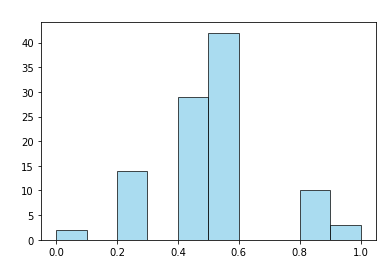

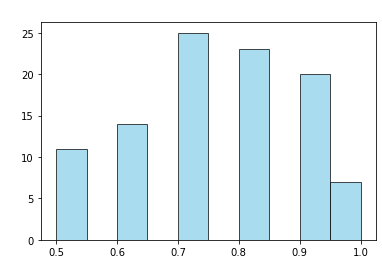

Average error rate= 0.506
Average correct rate= 0.748


In [23]:
# evesdropper measure all states sent by alice with R_basis and send all the same state (0 state)


from qiskit import*
from numpy.random import randint
import random
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
import statistics

num_qubits = 10
num_check = 5

# Alice generate photon with basis and message want to send
def circ(state, basis):
    num_qubits = len(state)
    circuit = QuantumCircuit(num_qubits)
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# eve perform measurement with R basis and get result
def evecirc(message):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(num_qubits, num_qubits)
    circuit.initialize(message, length)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub =  circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    int_array = np.array(str_array, dtype=int).astype(np.int32)
    return int_array

# According to the result, eve resend photon with R basis
#def evesend(everesult):
#    circuit = QuantumCircuit(len(everesult))
#    for i in range(len(everesult)):
#        if everesult[i] == 1:
#            circuit.x(i)
#    simulater = Aer.get_backend('statevector_simulator')
#    new_circuit = transpile(circuit, simulater)
#    job = simulater.run(new_circuit)
#    result = job.result()
#    statevector = result.get_statevector()
#    return statevector

# bob change the state according to his key
def bobchange(change):
    length = list(range(num_qubits))
    circuit1 = QuantumCircuit(len(change),len(change))
    #circuit1.initialize(state, length)
    for i in range(len(change)):
        if change[i] == 1:
            circuit1.z(i)
            circuit1.x(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit1, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# generate raw key after bob send k_B to alice
def generatekey(alice, bob):
    matrix = []
    for i in range(len(alice)):
        matrix.append((alice[i]+bob[i]) % 2)
    return matrix

# bob perform measurement according to basis alice sent
def measure(state, basis):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(len(basis),len(basis))
    circuit.initialize(state, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub = circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    key_bob = np.array(str_array, dtype=int).astype(np.int32)
    return key_bob

# compute error rate of check bits
def error(key_bob, raw_key):
    error_bit = 0
    total_check_bit = 0
    for i in check_bits:
        if key_bob[i] != raw_key[i]:
            error_bit += 1
        total_check_bit += 1
    rate = error_bit / total_check_bit
    return rate

#compute correction rate that eavesdropper obtain the right bit alice want to send
def correct(eve_key, alice_key):
    correct_bit = 0
    total_bit = 0
    for i in range(len(eve_key)):
        if eve_key[i] == alice_key[i]:
            correct_bit += 1
        total_bit += 1
    rate = correct_bit / total_bit
    return rate

# repeat the process 1000 times and see the distribution of error rate
errormatrix = []
correctmatrix = []
for i in range(100):
    alice_state = np.random.randint(2, size = num_qubits)
    alice_basis = np.random.randint(2, size = num_qubits)
    bob_change = np.random.randint(2, size = num_qubits)
    check_bits = sorted(random.sample(range(num_qubits), num_check))
    alice_message = circ(alice_state, alice_basis)
    everesult = evecirc(alice_message)
    #evestate = evesend(everesult)
    bobstate = bobchange(bob_change)
    key = generatekey(alice_state, bob_change)
    key_bob = measure(bobstate, alice_basis)
    error_rate = error(key_bob, key)
    errormatrix.append(error_rate)
    correct_rate = correct(everesult, alice_state)
    correctmatrix.append(correct_rate)

plt.hist(errormatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Error rate distribution of 100 trials", color='white')
plt.xlabel("Error rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
plt.hist(correctmatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Correct rate distribution of 100 trials", color='white')
plt.xlabel("Correct rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
avg_rate = statistics.mean(errormatrix)
print("Average error rate=", avg_rate)
avg_correct_rate = statistics.mean(correctmatrix)
print("Average correct rate=", avg_correct_rate)
   


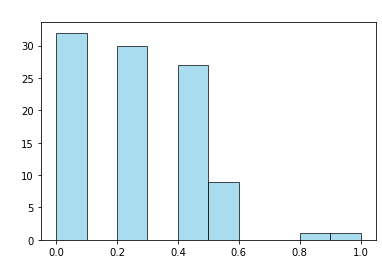

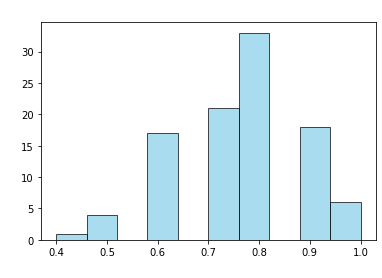

Average error rate= 0.24000000000000002
Average correct rate= 0.759


In [21]:
# evesdropper measure all states sent by alice with D_basis and resend the measured result


from qiskit import*
from numpy.random import randint
import random
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
import statistics

num_qubits = 10
num_check = 5

# Alice generate photon with basis and message want to send
def circ(state, basis):
    num_qubits = len(state)
    circuit = QuantumCircuit(num_qubits)
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# eve perform measurement with R basis and get result
def evecirc(message):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(num_qubits, num_qubits)
    circuit.initialize(message, length)
    for i in range(num_qubits):
        circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub =  circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    int_array = np.array(str_array, dtype=int).astype(np.int32)
    return int_array

# According to the result, eve resend photon with D basis
def evesend(everesult):
    circuit = QuantumCircuit(len(everesult))
    for i in range(len(everesult)):
        if everesult[i] == 1:
            circuit.x(i)
        circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# bob change the state according to his key
def bobchange(change, state):
    length = list(range(10))
    circuit1 = QuantumCircuit(len(change),len(change))
    circuit1.initialize(state, length)
    for i in range(len(change)):
        if change[i] == 1:
            circuit1.z(i)
            circuit1.x(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit1, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# generate raw key after bob send k_B to alice
def generatekey(alice, bob):
    matrix = []
    for i in range(len(alice)):
        matrix.append((alice[i]+bob[i]) % 2)
    return matrix

# bob perform measurement according to basis alice sent
def measure(state, basis):
    length = list(range(10))
    circuit = QuantumCircuit(len(basis),len(basis))
    circuit.initialize(state, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub = circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    key_bob = np.array(str_array, dtype=int).astype(np.int32)
    return key_bob

# compute error rate of check bits
def error(key_bob, raw_key):
    error_bit = 0
    total_check_bit = 0
    for i in check_bits:
        if key_bob[i] != raw_key[i]:
            error_bit += 1
        total_check_bit += 1
    rate = error_bit / total_check_bit
    return rate

#compute correction rate that eavesdropper obtain the right bit alice want to send
def correct(eve_key, alice_key):
    correct_bit = 0
    total_bit = 0
    for i in range(len(eve_key)):
        if eve_key[i] == alice_key[i]:
            correct_bit += 1
        total_bit += 1
    rate = correct_bit / total_bit
    return rate

# repeat the process 1000 times and see the distribution of error rate
errormatrix = []
correctmatrix = []
for i in range(100):
    alice_state = np.random.randint(2, size = num_qubits)
    alice_basis = np.random.randint(2, size = num_qubits)
    bob_change = np.random.randint(2, size = num_qubits)
    check_bits = sorted(random.sample(range(num_qubits), num_check))
    alice_message = circ(alice_state, alice_basis)
    everesult = evecirc(alice_message)
    evestate = evesend(everesult)
    bobstate = bobchange(bob_change, evestate)
    key = generatekey(alice_state, bob_change)
    key_bob = measure(bobstate, alice_basis)
    error_rate = error(key_bob, key)
    errormatrix.append(error_rate)
    correct_rate = correct(everesult, alice_state)
    correctmatrix.append(correct_rate)
    

plt.hist(errormatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Error rate distribution of 100 trials", color='white')
plt.xlabel("Error rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
plt.hist(correctmatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Correct rate distribution of 100 trials", color='white')
plt.xlabel("Correct rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
avg_rate = statistics.mean(errormatrix)
print("Average error rate=", avg_rate)
avg_correct_rate = statistics.mean(correctmatrix)
print("Average correct rate=", avg_correct_rate)


   


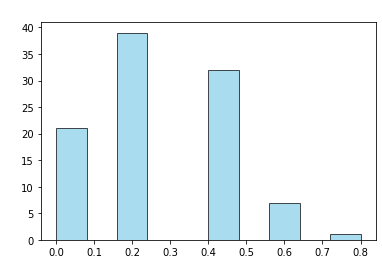

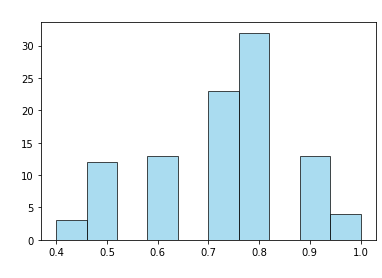

Average error rate= 0.256
Average correct rate= 0.724


In [20]:
# evesdropper measure states sent by alice with random basis and resend the measured result


from qiskit import*
from numpy.random import randint
import random
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt

num_qubits = 10
num_check = 5

# Alice generate photon with basis and message want to send
def circ(state, basis):
    num_qubits = len(state)
    circuit = QuantumCircuit(num_qubits)
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# eve perform measurement with random basis and get result
def evecirc(message, basis):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(num_qubits, num_qubits)
    circuit.initialize(message, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub =  circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    int_array = np.array(str_array, dtype=int).astype(np.int32)
    return int_array

# According to the result, eve resend photon with R basis
def evesend(everesult, basis):
    circuit = QuantumCircuit(len(everesult))
    for i in range(len(everesult)):
        if everesult[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# bob change the state according to his key
def bobchange(change, state):
    length = list(range(10))
    circuit1 = QuantumCircuit(len(change),len(change))
    circuit1.initialize(state, length)
    for i in range(len(change)):
        if change[i] == 1:
            circuit1.z(i)
            circuit1.x(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit1, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# generate raw key after bob send k_B to alice
def generatekey(alice, bob):
    matrix = []
    for i in range(len(alice)):
        matrix.append((alice[i]+bob[i]) % 2)
    return matrix

# bob perform measurement according to basis alice sent
def measure(state, basis):
    length = list(range(10))
    circuit = QuantumCircuit(len(basis),len(basis))
    circuit.initialize(state, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub = circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    key_bob = np.array(str_array, dtype=int).astype(np.int32)
    return key_bob

# compute error rate of check bits
def error(key_bob, raw_key):
    error_bit = 0
    total_check_bit = 0
    for i in check_bits:
        if key_bob[i] != raw_key[i]:
            error_bit += 1
        total_check_bit += 1
    rate = error_bit / total_check_bit
    return rate

#compute correction rate that eavesdropper obtain the right bit alice want to send
def correct(eve_key, alice_key):
    correct_bit = 0
    total_bit = 0
    for i in range(len(eve_key)):
        if eve_key[i] == alice_key[i]:
            correct_bit += 1
        total_bit += 1
    rate = correct_bit / total_bit
    return rate

# repeat the process 1000 times and see the distribution of error rate
errormatrix = []
correctmatrix = []
for i in range(100):
    alice_state = np.random.randint(2, size = num_qubits)
    alice_basis = np.random.randint(2, size = num_qubits)
    bob_change = np.random.randint(2, size = num_qubits)
    eve_basis = np.random.randint(2, size = num_qubits)
    check_bits = sorted(random.sample(range(num_qubits), num_check))
    alice_message = circ(alice_state, alice_basis)
    everesult = evecirc(alice_message, eve_basis)
    evestate = evesend(everesult, eve_basis)
    bobstate = bobchange(bob_change, evestate)
    key = generatekey(alice_state, bob_change)
    key_bob = measure(bobstate, alice_basis)
    error_rate = error(key_bob, key)
    errormatrix.append(error_rate)
    correct_rate = correct(everesult, alice_state)
    correctmatrix.append(correct_rate)

plt.hist(errormatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Error rate distribution of 100 trials", color='white')
plt.xlabel("Error rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
plt.hist(correctmatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Correct rate distribution of 100 trials", color='white')
plt.xlabel("Correct rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
avg_rate = statistics.mean(errormatrix)
print("Average error rate=", avg_rate)
avg_correct_rate = statistics.mean(correctmatrix)
print("Average correct rate=", avg_correct_rate)
   


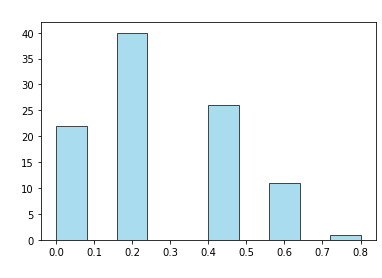

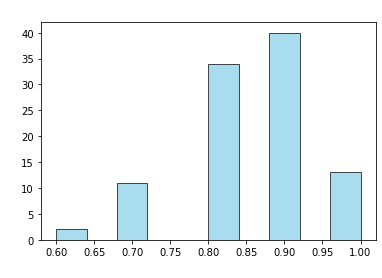

Average error rate= 0.258
Average correct rate= 0.851


In [25]:
# evesdropper measure all states sent by alice with Breidbart basis and resend the measured result


from qiskit import*
from numpy.random import randint
import random
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
import math



# Alice generate photon with basis and message want to send
def circ(state, basis):
    circuit = QuantumCircuit(len(state))
    for i in range(len(basis)):
        if state[i] == 1:
            circuit.x(i)
        if basis[i] == 1:
            circuit.h(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# eve perform measurement with Breidbart basis and get result
def evecirc(message):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(num_qubits, num_qubits)
    circuit.initialize(message, length)
    for i in range(num_qubits):
        circuit.ry(-math.pi/4, i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub =  circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    int_array = np.array(str_array, dtype=int).astype(np.int32)
    return int_array

# According to the result, eve resend photon with Breidbart basis
def evesend(everesult):
    circuit = QuantumCircuit(len(everesult))
    for i in range(len(everesult)):
        if everesult[i] == 1:
            circuit.x(i)
        circuit.ry(math.pi/4, i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# bob change the state according to his key
def bobchange(change, state):
    length = list(range(num_qubits))
    circuit1 = QuantumCircuit(len(change),len(change))
    circuit1.initialize(state, length)
    for i in range(len(change)):
        if change[i] == 1:
            circuit1.z(i)
            circuit1.x(i)
    simulater = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(circuit1, simulater)
    job = simulater.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()
    return statevector

# generate raw key after bob send k_B to alice
def generatekey(alice, bob):
    matrix = []
    for i in range(len(alice)):
        matrix.append((alice[i]+bob[i]) % 2)
    return matrix

# bob perform measurement according to basis alice sent
def measure(state, basis):
    length = list(range(num_qubits))
    circuit = QuantumCircuit(len(basis),len(basis))
    circuit.initialize(state, length)
    for i in range(len(basis)):
        if basis[i] == 1:
            circuit.h(i)
    circuit.measure_all()
    sampler = StatevectorSampler()
    pub = circuit
    job = sampler.run([pub], shots = 1).result()
    result = job[0].data.meas.get_counts()
    result_list = list(result.keys())[0]
    reversed_string = result_list[::-1]
    str_array = list(reversed_string)
    key_bob = np.array(str_array, dtype=int).astype(np.int32)
    return key_bob

# compute error rate of check bits
def error(key_bob, raw_key):
    error_bit = 0
    total_check_bit = 0
    for i in check_bits:
        if key_bob[i] != raw_key[i]:
            error_bit += 1
        total_check_bit += 1
    rate = error_bit / total_check_bit
    return rate

#compute correction rate that eavesdropper obtain the right bit alice want to send
def correct(eve_key, alice_key):
    correct_bit = 0
    total_bit = 0
    for i in range(len(eve_key)):
        if eve_key[i] == alice_key[i]:
            correct_bit += 1
        total_bit += 1
    rate = correct_bit / total_bit
    return rate

# repeat the process 100 times and see the distribution of error rate
errormatrix = []
correctmatrix = []
num_qubits = 10
num_check = 5
for i in range(100):
    alice_state = np.random.randint(2, size = num_qubits)
    alice_basis = np.random.randint(2, size = num_qubits)
    bob_change = np.random.randint(2, size = num_qubits)
    check_bits = sorted(random.sample(range(num_qubits), num_check))
    alice_message = circ(alice_state, alice_basis)
    everesult = evecirc(alice_message)
    evestate = evesend(everesult)
    bobstate = bobchange(bob_change, evestate)
    key = generatekey(alice_state, bob_change)
    key_bob = measure(bobstate, alice_basis)
    error_rate = error(key_bob, key)
    errormatrix.append(error_rate)
    correct_rate = correct(everesult, alice_state)
    correctmatrix.append(correct_rate)

plt.hist(errormatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Error rate distribution of 100 trials", color='white')
plt.xlabel("Error rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
plt.hist(correctmatrix, bins = 10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Correct rate distribution of 100 trials", color='white')
plt.xlabel("Correct rate", color='white')
plt.ylabel("Times", color='white')
plt.show()
avg_error_rate = statistics.mean(errormatrix)
print("Average error rate=", avg_error_rate)
avg_correct_rate = statistics.mean(correctmatrix)
print("Average correct rate=", avg_correct_rate)
